In [6]:
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution

In [28]:
# number of qubits to represent the uncertainty for our probability distribution
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
# uncertainty_model = LogNormalDistribution(
#     num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
# )
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

[1.20860724 1.43785917 1.66711109 1.89636302 2.12561495 2.35486687
 2.5841188  2.81337073]
[1.20860724 1.43785917 1.66711109 1.89636302 2.12561495 2.35486687
 2.5841188  2.81337073]


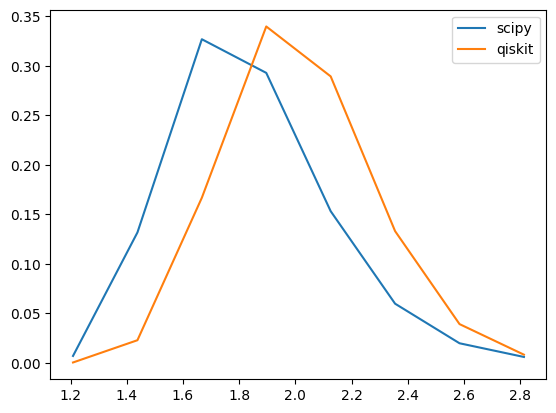

In [31]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt

x = np.linspace(low, high, 8)
print(x)
print(uncertainty_model.values)
y = lognorm.pdf(x, s=stddev, loc=mu)

# y = lognorm.cdf(x, s=stddev, loc=mu)
step = x[1]-x[0]

prob = []

for i in range(len(x)):
    prob.append(lognorm.cdf(uncertainty_model.values[i], s=stddev, loc=mu) - lognorm.cdf(uncertainty_model.values[i]-step, s=stddev, loc=mu))

plt.plot(uncertainty_model.values,prob, label= "scipy")
plt.plot(uncertainty_model.values, uncertainty_model.probabilities, label="qiskit")
plt.legend()
